<a href="https://colab.research.google.com/github/huyhoangpjn/doan/blob/master/DOAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-gpu==1.15

In [ ]:
#check this
import tensorflow as tf 

print(tf.__version__)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

a = tf.constant(1)
b = tf.constant(2) 

print(sess.run(a+b)) 

1.15.0
3


In [ ]:
pip install gdown

In [ ]:
!gdown https://drive.google.com/uc?id=1VoyW4d0e6iTqhtYr2PcoZNOkPIfint5r
!gdown https://drive.google.com/uc?id=1eVHcOdi8HZi-6QO43b_A7OSgGtVOTOm6
!gdown https://drive.google.com/uc?id=1dtGZ4hvr-WYt8R75U94kR50jc_sidMe3
!gdown https://drive.google.com/uc?id=1IZbZPfbxg7jjOdxNb_AGU2WoIl9Ayw_H
!gdown https://drive.google.com/uc?id=1Kxen0y7qKRFXfkaMHMJCHeDitLdgsbzh
#DL CUDA 10.0 libs
!gdown https://drive.google.com/uc?id=1-1EAv6wt1z0BQjZiw_PnezXkvuSXPrO8
!gdown https://drive.google.com/uc?id=1fI0a-QtuugLpfMZUVZZw1bt0mJXeILp6
!gdown https://drive.google.com/uc?id=1-2_yPVMMbnFdJw_qQ5Z-FtWlDhSbPKd-
!gdown https://drive.google.com/uc?id=1-4FEExV7WXr-NSX6jX6gj5fjweE7Oe3K
!gdown https://drive.google.com/uc?id=1-LGr92Wq2_9KZv2xF4bmrRRIjEFS2Q58
!gdown https://drive.google.com/uc?id=1-MKOSamwVvj0Upi-tToruRPSHYB3z8Yb

In [ ]:
!pip install --upgrade moviepy
!pip install numpy
!pip install matplotlib==2.2.2
!pip install scipy==1.1.0
!pip install keras==2.3.1
!pip install imutils
!pip install opencv_python
!pip install glob

In [ ]:
#Clone Git repository and get prepared
# %tensorflow_version 1.x

import glob
import os
import cv2
import math
import pickle
import imageio
import warnings
import PIL.Image
import numpy as np
from PIL import Image
import tensorflow as tf
from random import randrange
import moviepy.editor as mpy
#from google.colab import drive
#from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import clear_output
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
# %matplotlib inline
warnings.filterwarnings("ignore")

def get_watermarked(pil_image: Image) -> Image:
  try:
    image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    (h, w) = image.shape[:2]
    image = np.dstack([image, np.ones((h, w), dtype="uint8") * 255])
    pct = 0.08
    full_watermark = cv2.imread('/content/drive/MyDrive/kaggle/working/BabyGAN/media/logo.png', cv2.IMREAD_UNCHANGED)
    (fwH, fwW) = full_watermark.shape[:2]
    wH = int(pct * h*2)
    wW = int((wH * fwW) / fwH*0.1)
    watermark = cv2.resize(full_watermark, (wH, wW), interpolation=cv2.INTER_AREA)
    overlay = np.zeros((h, w, 4), dtype="uint8")
    (wH, wW) = watermark.shape[:2]
    overlay[h - wH - 10 : h - 10, 10 : 10 + wW] = watermark
    output = image.copy()
    cv2.addWeighted(overlay, 0.5, output, 1.0, 0, output)
    rgb_image = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    return Image.fromarray(rgb_image)
  except: return pil_image


def generate_final_image(latent_vector, direction, coeffs):
    new_latent_vector = latent_vector.copy()
    new_latent_vector[:8] = (latent_vector + coeffs*direction)[:8]
    new_latent_vector = new_latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(new_latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    #if size[0] >= 2048: img = get_watermarked(img)
    img.thumbnail(size, PIL.Image.ANTIALIAS)
    img.save("face.png")
    if download_image == True: files.download("face.png")
    return img

def plot_three_images(imgB, fs = 10):    #fix later
  f, axarr = plt.subplots(1,3, figsize=(fs,fs))
  axarr[0].imshow(Image.open('/content/drive/MyDrive/kaggle/working/BabyGAN/aligned_images/nuvuong10.png'))
  axarr[0].title.set_text("Dad")
  axarr[1].imshow(imgB)
  axarr[1].title.set_text("Hình ảnh được sinh ra")
  axarr[2].imshow(Image.open('/content/drive/MyDrive/kaggle/working/BabyGAN/aligned_images/nuvuong11.png'))
  axarr[2].title.set_text("Mom")
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

#!git clone https://github.com/tg-bomze/BabyGAN.git
%cd /content/drive/MyDrive/kaggle/working/BabyGAN           #add your path
#!mkdir aligned_images data father_image mother_image

import config
import dnnlib
import dnnlib.tflib as tflib
from encoder.generator_model import Generator

age_direction = np.load('/content/drive/MyDrive/kaggle/working/BabyGAN/ffhq_dataset/latent_directions/age.npy')          #add your path
horizontal_direction = np.load('/content/drive/MyDrive/kaggle/working/BabyGAN/ffhq_dataset/latent_directions/angle_horizontal.npy')
vertical_direction = np.load('/content/drive/MyDrive/kaggle/working/BabyGAN/ffhq_dataset/latent_directions/angle_vertical.npy')
eyes_open_direction = np.load('/content/drive/MyDrive/kaggle/working/BabyGAN/ffhq_dataset/latent_directions/eyes_open.npy')
gender_direction = np.load('/content/drive/MyDrive/kaggle/working/BabyGAN/ffhq_dataset/latent_directions/gender.npy')
smile_direction = np.load('/content/drive/MyDrive/kaggle/working/BabyGAN/ffhq_dataset/latent_directions/smile.npy')
print("step1 ok.")
#clear_output()

/content/drive/MyDrive/kaggle/working/BabyGAN
step1 ok.


In [ ]:
!cp -a /content/drive/MyDrive/Dataproject/male/Wales/. /content/drive/MyDrive/kaggle/working/BabyGAN/father_image    #add data

In [ ]:
ft = plt.imread('/content/drive/MyDrive/kaggle/working/BabyGAN/father_image/father.png')    #dont need to run this cell
ft = plt.imshow(ft)
plt.show()

In [ ]:
#cd ..
#Copy pretrained models into BabyGAN folder
#!cp finetuned_resnet.h5 /content/drive/MyDrive/kaggle/working/BabyGAN/data
#!cp karras2019stylegan-ffhq-1024x1024.pkl /content/drive/MyDrive/kaggle/working/BabyGAN
#!cp shape_predictor_68_face_landmarks.dat.bz2 /content/drive/MyDrive/kaggle/working/BabyGAN
#!cp vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5 /content/drive/MyDrive/kaggle/working/BabyGAN
#!cp vgg16_zhang_perceptual.pkl /content/drive/MyDrive/kaggle/working/BabyGAN
#Done
#cd BabyGAN

In [ ]:
#Get and locate father face image png
!python /content/drive/MyDrive/kaggle/working/BabyGAN/align_images.py /content/drive/MyDrive/kaggle/working/BabyGAN/father_image /content/drive/MyDrive/kaggle/working/BabyGAN/aligned_images



#father_path = "/content/drive/MyDrive/kaggle/working/BabyGAN/father_image/" + "father.png"
#pil_father = Image.open('/content/drive/MyDrive/kaggle/working/BabyGAN/father_image/father.png')       
#if os.path.isfile('/content/drive/MyDrive/kaggle/working/BabyGAN/aligned_images/father.png'):
  #pil_father = Image.open('/content/drive/MyDrive/kaggle/working/BabyGAN/aligned_images/father.png')
  #(fat_width, fat_height) = pil_father.size
  #resize_fat = max(fat_width, fat_height)/256
  #display(pil_father.resize((int(fat_width/resize_fat), int(fat_height/resize_fat))))
#else: raise ValueError('Không tìm thấy khuôn mặt hoặc nhiều khuôn mặt trong 1 ảnh.'

In [ ]:
!cp -a /content/drive/MyDrive/Dataproject/female/QueenElizabethII/. /content/drive/MyDrive/kaggle/working/BabyGAN/mother_image   #add data

In [ ]:
!python /content/drive/MyDrive/kaggle/working/BabyGAN/align_images.py /content/drive/MyDrive/kaggle/working/BabyGAN/mother_image /content/drive/MyDrive/kaggle/working/BabyGAN/aligned_images
        
#mother_path = "/content/drive/MyDrive/kaggle/working/BabyGAN/mother_image/" + "mother.png"
#pil_mother = Image.open('/content/drive/MyDrive/kaggle/working/BabyGAN/mother_image/mother.png')       
#if os.path.isfile('/content/drive/MyDrive/kaggle/working/BabyGAN/aligned_images/mother.png'):
  #pil_mother = Image.open('/content/drive/MyDrive/kaggle/working/BabyGAN/aligned_images/mother.png')
  #(fat_width, fat_height) = pil_mother.size
  #resize_fat = max(fat_width, fat_height)/256
  #display(pil_mother.resize((int(fat_width/resize_fat), int(fat_height/resize_fat))))
#else: raise ValueError('Không tìm thấy khuôn mặt hoặc nhiều khuôn mặt trong 1 ảnh.')

In [ ]:
#Generation of latent representation, this step may take 3 minutes
use_pretraineg_model = True
if use_pretraineg_model == False:
  !rm finetuned_resnet.h5
  !python train_resnet.py \
  --test_size 256 \
  --batch_size 1024 \
  --loop 1 \
  --max_patience 1'''

!python /content/drive/MyDrive/kaggle/working/BabyGAN/encode_images.py \
  --early_stopping False \
  --lr=0.25 \
  --batch_size=2 \
  --iterations=100 \
  --output_video=False \
  /content/drive/MyDrive/kaggle/working/BabyGAN/aligned_images \
  /content/drive/MyDrive/kaggle/working/BabyGAN/generated_images \
  /content/drive/MyDrive/working/BabyGAN/latent_representations


print("Hoàn tất lấy vector ảnh!!!!!!!!.")

In [ ]:
tflib.init_tf()
URL_FFHQ = "/content/drive/MyDrive/kaggle/working/BabyGAN/karras2019stylegan-ffhq-1024x1024.pkl"
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)
generator = Generator(Gs_network, batch_size=1, randomize_noise=False)
model_scale = int(2*(math.log(1024,2)-1))
faces = []
totalface = 0
for latent in glob.glob('/content/drive/MyDrive/working/BabyGAN/latent_representations/*'):
  faces.append(np.load(latent))
  totalface += 1
print(totalface)

101


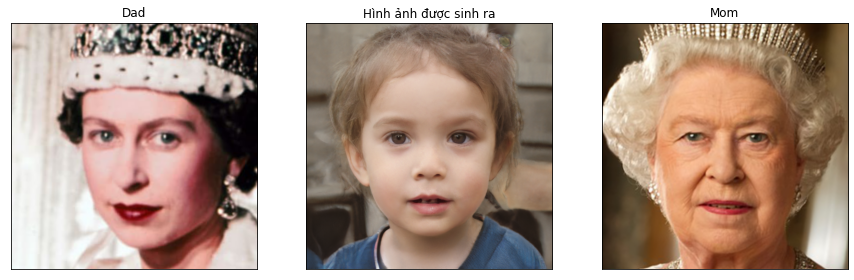

Tổng các ảnh trong bộ dataset:  101


In [ ]:
#Generating a child's face with more parameters

#@markdown *The closer to 0, the more influence the father's genotype will have. Closer to 1 - mother.*
#Fix later

genes_influence = 0.5 #@param {type:"slider", min:0.01, max:0.99, step:0.01}

#@markdown **Styling a photo:**
style = "Default" #@param ["Default", "Father's photo", "Mother's photo"]
if style == "Father's photo": 
  lr = ((np.arange(1,model_scale+1)/model_scale)**genes_influence).reshape((model_scale,1))
  rl = 1-lr
  hybrid_face = (lr*faces[0]) + (rl*faces[1])
elif style == "Mother's photo": 
  lr = ((np.arange(1,model_scale+1)/model_scale)**(1-genes_influence)).reshape((model_scale,1))
  rl = 1-lr
  hybrid_face = (rl*faces[0]) + (lr*faces[1])
else:
  hybrid_face = 0
  for i in range(0,totalface): 
    hybrid_face += (1/totalface)*faces[i]

#@markdown **Option intensity:**
horizontal = -5 #@param {type:"slider", min:-100, max:100, step:1}
horizontal_intensity = horizontal/50
vertical = 0 #@param {type:"slider", min:-100, max:100, step:1}
vertical_intensity = vertical/50
eyes_open = 0 #@param {type:"slider", min:-100, max:100, step:1}
eyes_open_intensity = -(eyes_open/25)
gender = 35 #@param {type:"slider", min:-100, max:100, step:1}
gender_intensity = gender/100
smile = -29 #@param {type:"slider", min:-100, max:100, step:1}
smile_intensity = smile/100
age = 10 #@param {type:"slider", min:-100, max:100, step:1}
age_intensity = -((age/5)-6)

direction_intensity = (horizontal_direction*horizontal_intensity) + (vertical_direction*vertical_intensity) + (eyes_open_direction*eyes_open_intensity) + (gender_direction*gender_intensity) + (smile_direction*smile_intensity) + (age_direction*age_intensity)
download_image = False
#@markdown **Resolution of the downloaded image:**
resolution = "512" #@param [256, 512, 1024]
size = int(resolution), int(resolution)

face = generate_final_image(hybrid_face, direction_intensity, 1)
plot_three_images(face, fs =15)
print("Tổng các ảnh trong bộ dataset: ", totalface)

In [ ]:
!pip install numba
from numba import cuda 
device = cuda.get_current_device()
device.reset()#reset graph

import subprocess as sp
import os

def get_gpu_memory():
  _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

  ACCEPTABLE_AVAILABLE_MEMORY = 1024
  COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
  memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
  memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
  print(memory_free_values)
  return memory_free_values

get_gpu_memory()

[16278]


[16278]

In [ ]:
#remove data to generate new
!rm -r /content/drive/MyDrive/kaggle/working/BabyGAN/masks/*
!rm -r /content/drive/MyDrive/kaggle/working/BabyGAN/generated_images/*
!rm -r /content/drive/MyDrive/working/BabyGAN/latent_representations/*
!rm -r /content/drive/MyDrive/kaggle/working/BabyGAN/aligned_images/*
!rm -r /content/drive/MyDrive/kaggle/working/BabyGAN/father_image/*
!rm -r /content/drive/MyDrive/kaggle/working/BabyGAN/mother_image/*
